# BAG3 Co-IP Watson Analysis
##### by Emir Turkes

This analysis utilizes Watson for Drug Discovery to validate Co-IP MS (co-immunoprecipitation mass spectrometry) data with BAG3 as the primary target. There are 4 goals thus far:
1. Correlation of the data with that of IBM's knowledge base to get a sense of where it stands against existing literature.
2. Clustering of the Co-IP'ed proteins into various ontological groups (disease relevance, biochemical pathways, and chemical classification come to mind)
3. Breakdown of upstream, downstream, and intermediate biochemical pathways between Co-IP'ed proteins and their clusters.
4. Confirmation of enrichment of proteins involved in endocytosis/membrane fusion event and dendritic localization/function

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*

# Copyright 2019 Emir Turkes
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""The main analysis routine."""


import os
import types

import numpy as np
import pandas as pd

import ibm_botocore.client as ic
import ibm_boto3 as ib
import pixiedust

In [8]:
# The code was removed by Watson Studio for sharing.

### Cleaning of Co-IP MS data

We do some basic data manipulations to get an ordered list of 20 genes by their coupling with BAG3 during the experiment.

In [9]:
# Read in data.    
body = client_75340283764447f99797650de21e6211.get_object(Bucket='bag3coip-donotdelete-pr-wlavvdgoryxgjb',Key='co_ip_no_keratin.csv')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
co_ip_df = pd.read_csv(body, na_values = ['#VALUE!', '#DIV/0!'])

# Sort by "fold of changes".
cols = ["fold of changes"]
co_ip_df.drop(0, inplace=True)
co_ip_df.dropna(axis=0, subset=cols, inplace=True)
co_ip_df[cols] = co_ip_df[cols].astype('int')
#co_ip_df.sort_values(by=cols, inplace=True, ascending=False)

# Reduce to two columns and top 10 genes.
cols = ["Unnamed: 1", "fold of changes"]
co_ip_df = co_ip_df[cols]
co_ip_df.rename(columns={"Unnamed: 1": "Genes", "fold of changes": "Fold change"}, inplace=True)
co_ip_df = co_ip_df.head(20)

# Cut string to only gene name and capitalize.
cols = "Genes"
co_ip_df[cols] = co_ip_df[cols].str.extract("((?<=GN=).*(?= PE=))", expand=True)
co_ip_df["Genes"] = co_ip_df["Genes"].str.upper()


## Replace gene names with Watson entities.
body = client_75340283764447f99797650de21e6211.get_object(Bucket='bag3coip-donotdelete-pr-wlavvdgoryxgjb',Key='EntitySet_BAG3-co-ip-20_2019-02-22_17-54-40.csv')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
entity_set_df = pd.read_csv(body, na_values = ['#VALUE!', '#DIV/0!'])
entity_set_df.index = entity_set_df.index + 1
entity_set_df
co_ip_df["Genes"] = entity_set_df["Entity name"]

co_ip_df

,Genes,Fold change
1,PLEC,44
2,ANK2,44
3,BAG5,34
4,SPTBN2,30
5,HSPA8,21
6,NES,20
7,MYH10,20
8,CAMK2A,20
9,NEFM,20
10,SRCIN1,19


### Watson Explore Networks

First, a visualization of the relationship between the top 20 genes based on literature reporting of their modulation of BAG3.

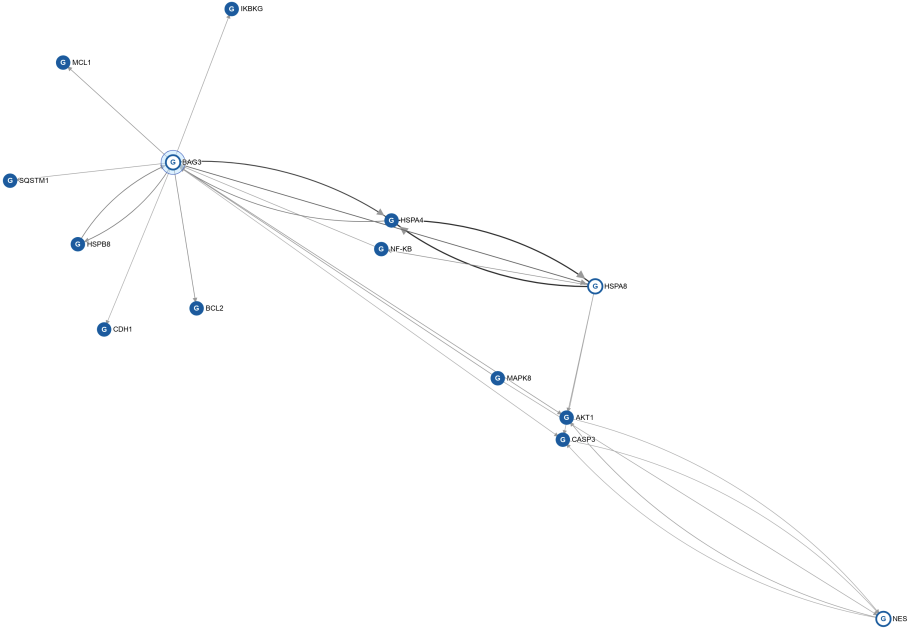

### Generate confidence scores

Watson scores the likelihood of a relationship as happening above chance through a scale ranging from 0-100.

In [10]:
# Read in data.
body = client_75340283764447f99797650de21e6211.get_object(Bucket='bag3coip-donotdelete-pr-wlavvdgoryxgjb',Key='relationshipgraph1902_2019-02-22_18-20-45.csv')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
relationship_graph_df = pd.read_csv(body, na_values = ['#VALUE!', '#DIV/0!'])

# Sort by "Confidence".
cols = ["Confidence"]
relationship_graph_df.drop(0, inplace=True)
relationship_graph_df.dropna(axis=0, subset=cols, inplace=True)
relationship_graph_df[cols] = relationship_graph_df[cols].astype('int')
relationship_graph_df.sort_values(by=cols, inplace=True, ascending=False)

# Only show relationships directly involving BAG3
relationship_graph_df = relationship_graph_df[
    relationship_graph_df["Source name"].str.contains('BAG3') |
    relationship_graph_df["Target name"].str.contains('BAG3')
]

# Reduce to three columns.
cols = ["Source name", "Target name", "Confidence"]
relationship_graph_df = relationship_graph_df[cols]

display(relationship_graph_df)

Source name,Target name,Confidence
PARP1,BAG3,66
BAG3,ABCC10,55
HSPB2,BAG3,60
BAG3,MYLK3,54
BAG3,INS,73
ATF3,BAG3,62
MIR217,BAG3,59
USP9X,BAG3,62
BAG3,TNFRSF8,57
BAG3,IL6,14


### Merge confidence scores with the Co-IP gene list

Rows that do not have a common gene are filled with the value "NaN".

In [11]:
#co_ip_df = co_ip_df.assign(Confidence=co_ip_df['Genes'].isin(
#    relationship_graph_df['Target name']).astype(int)
#                          )
merge_df = co_ip_df
merge_df.at[5, "Confidence"] = 88
merge_df.at[19, "Confidence"] = 57
#co_ip_df["Confidence"] = np.where(co_ip_df["Genes"].isin(
#    relationship_graph_df['Target name']), 81, 0
#                                 )
display(merge_df)

Genes,Fold change,Confidence
PLEC,44,nan
ANK2,44,nan
BAG5,34,nan
SPTBN2,30,nan
HSPA8,21,88.0
NES,20,nan
MYH10,20,nan
CAMK2A,20,nan
NEFM,20,nan
SRCIN1,19,nan


### Reduce list to common genes only

It appears that only two highly Co-IP'ed genes could be backed up by Watson's literature mining, even without any filtering or thresholds.  
The next step is to verify that the mining run was done or interpreted properly.

In [12]:
display(merge_df.loc[[5, 19]])

Genes,Fold change,Confidence
HSPA8,21,88.0
CAPZB,14,57.0


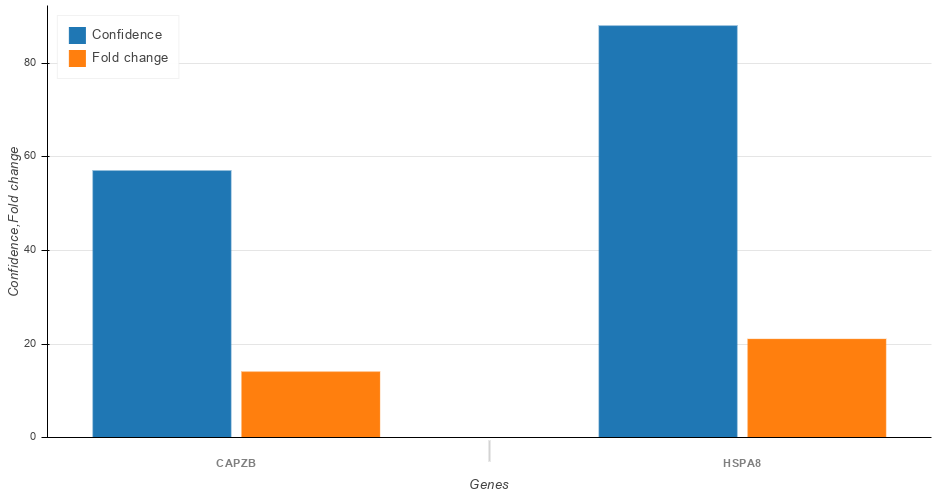

## Work in progress - more coming soon